### Import packages

In [1]:
# Package(s) related to time, space and id
import datetime, time
from datetime import timedelta
import platform
import random
import os

# You need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# Spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# Package(s) for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Tranport network analysis package
import transport_network_analysis.core as core
import transport_network_analysis.graph_module as graph_module
import transport_network_analysis.model as model

# Used for mathematical functions
import math             
from numpy.random import choice
from bisect import bisect
from collections import Counter

# Used for making the graph to visualize our problem
import networkx as nx  

### Import data for stations and transport lines

In [2]:
# Import stations and lines from csv 
df1 = pd.read_csv("Data/stations.csv", sep=";")
df2 = pd.read_csv("Data/lines.csv", sep=";")

# Convert columns to lst type
from ast import literal_eval
df2.loc[:,'Route1'] = df2.loc[:,'Route1'].apply(lambda x: literal_eval(x))
df2.loc[:,'Route2'] = df2.loc[:,'Route2'].apply(lambda x: literal_eval(x))
df2.loc[:,'Duration'] = df2.loc[:,'Duration'].apply(lambda x: literal_eval(x)) 
df1.loc[:,'HalteLon'] = df1.loc[:,'HalteLon'].apply(lambda x: float(str(x).replace(',','.')))
df1.loc[:,'HalteLat'] = df1.loc[:,'HalteLat'].apply(lambda x: float(str(x).replace(',','.')))

In [3]:
# Create dictionary for all transport lines
lines = {}
durations = []

for index, row in df2.iterrows():
    lines[row["Line"] + "_0"] = (row["Route1"], row["Duration"], row["Start1"], row["Frequency"])
    lines[row["Line"] + "_1"] = (row["Route2"], row["Duration"], row["Start2"], row["Frequency"])
    
edges = []
for k, v in lines.items():
    for x in range(len(v[0])):
        try:
            edges.append((v[0][x], v[0][x + 1], k, v[1][x]))
        except:
            break

### Create graph

In [4]:
# Create graph
FG = nx.DiGraph()

# Create all stations and nodes
Node = type('Station', (core.Identifiable, core.Log, core.Locatable, core.HasResource, core.Station), {})
nodes = []
stations = []

for index, row in df1.iterrows():
    stations.append({"env": [],
                     "name": row["HalteNaam"],
                     "geometry": shapely.geometry.Point(row["HalteLat"], row["HalteLon"]),
                     "capacity": row["Capacity"]}) 

for station in stations:
    node = Node(**station)
    nodes.append(node)

# Create positions and add nodes to graph with right position
positions = {}

for node in nodes:
    positions[node.name] = (node.geometry.y, node.geometry.x)
    FG.add_node(node.name, geometry = node.geometry, object_type = node)

# Create all edges
for edge in edges:
    FG.add_edge(edge[0], edge[1], line = edge[2], duration = edge[3])

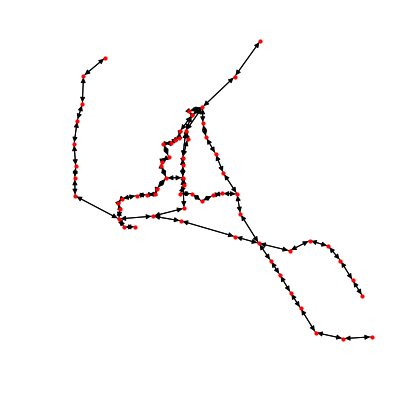

In [5]:
# Plot the network
plt.figure(figsize=[5,5]) 
nx.draw(FG, positions, node_size=10)
# plt.savefig("../../graph.png", format="PNG")

### Route calculation and choice functions
#### Correctly calculate duration > including transfertime
#### Correctly calculate waiting time > time before start of the trip

In [6]:
def waitingtime(schedule, line, station, time):
    """
    Calculate waiting time before next line arrives.
    """
    if time in schedule[line][station]:
        waiting = 0
        
    else:
        lineschedule = schedule[line][station]
        waiting = (lineschedule[bisect(lineschedule, time)] - time).seconds/60

    return waiting

In [7]:
# These functions are used to check for edges which are used by
# multiple lines. For further iterations, using a MultiDiGraph
# could also be a solution, but heuristics are needed.

def checkduplicates(route):
    """
    There is one overlapping route in the network.
    This function checks for the duplicate in the route. 
    """
    if ('Roelof Hartplein', 'De Pijp') in zip(route, route[1:]):
        return True
    elif ('De Pijp', 'Roelof Hartplein') in zip(route, route[1:]):
        return True
    else:
        return False

def checkedge(station1, station2):
    """
    Check whether an edge is the duplicate.
    """
    if station1 == 'Roelof Hartplein' or station2 == 'Roelof Hartplein':
        if station1 == 'De Pijp' or station2 == 'De Pijp':
            return True
        else:
            return False
    else:
        return False

In [1]:
def route_calculation(env, route, graph, exception):
    """
    Calculate all route variables. The exception parameter
    is used for overlapping lines only, so both options
    are calculated.
    """
    schedule = env.timeschedule
    route_info = {"lines": [], "duration": 0, "transfers": 0, "waiting": 0, "transferstations": []}    

    for i in range(len(route) - 1):
        if route_info["lines"] != []:
            attr = FG.get_edge_data(route[i],route[i+1],default=0)
            newline = ''
            if checkedge(route[i], route[i+1]) == True:
                newline = exception + attr['line'][-2:]
            else:  
                newline = attr['line']
                
            if line != newline:
                # If there is a new line in the route, this is a transfer
                # Add transfers to the route information
                route_info["transfers"] += 1
                route_info["transferstations"].append(route[i])
                route_info["lines"].append(newline)
                line = newline
                
                duration = route_info["duration"] + route_info["waiting"]
                time = datetime.datetime.fromtimestamp(env.now) + timedelta(minutes = duration + 5)
                
                route_info["duration"] += waitingtime(schedule, line, route[i], time)
                
            route_info["duration"] += attr['duration']
        
        else:
            attr = FG.get_edge_data(route[i],route[i+1],default=0)
            if checkedge(route[i], route[i+1]) == True:
                line = exception + attr['line'][-2:]
            else:
                line = attr['line']
            
            # Add line number
            route_info["lines"].append(line)
            
            # Calculate waiting time
            route_info["waiting"] = waitingtime(schedule, line, route[i], datetime.datetime.fromtimestamp(env.now))
            
            # Calculate duration
            route_info["duration"] += attr['duration']

    return route_info

In [9]:
def calculate_schedule(lines, simhours, start):
    """
    Calculate schedule for a particular line
    """
    simulation_end = start + timedelta(hours = simhours)
    schedule = {}
    
    for line in lines:
        lineschedule = {}
        frequency = lines[line][3]
        now = start + timedelta(minutes = lines[line][2])
        timeschedule = [now]
        now = now + timedelta(minutes = frequency)
        
        while now < simulation_end:
            timeschedule.append(now)
            now = now + timedelta(minutes = frequency)
            
        lineschedule[lines[line][0][0]] = timeschedule

        for i in range(len(lines[line][0]) - 1):
            duration = lines[line][1][i]
            timeschedule = [x + timedelta(minutes = duration) for x in timeschedule]
            lineschedule[lines[line][0][i + 1]] = timeschedule
            
        schedule[line] = lineschedule
        
    return schedule

In [10]:
def route_choice(env, routes, classname):
    """
    Choose route from a list of routes based on 
    preferences with a certain class.
    """
    if classname == 1:
        minimum = routes[0][0]["duration"]
        index = 0
        for i in range(1, len(routes)):
            # Loop through all routes and save the route with the shortest trip duration
            if routes[i][0]["duration"] < minimum:
                minimum = routes[i][0]["duration"]
                index = i

            # If the duration is the same, save the route with the least waiting time
            elif routes[i][0]["duration"] == minimum:
                if routes[i][0]["waiting"] < routes[index][0]["waiting"]:
                    index = i

    elif classname == 2:
        minimum = routes[0][0]["waiting"]
        index = 0
        for i in range(1, len(routes)):
            # Loop through all routes and save the route with the least waiting time
            if routes[i][0]["waiting"] < minimum:
                minimum = routes[i][0]["waiting"]
                index = i

            # If waiting time is the same, save the route with the shortest duration
            elif routes[i][0]["waiting"] == minimum:
                if routes[i][0]["transfers"] < routes[index][0]["transfers"]:
                    index = i

    elif classname == 3:
        minimum = routes[0][0]["transfers"]
        index = 0
        for i in range(1, len(routes)):
            # Loop through all routes and save the route with the least transfers
            if routes[i][0]["transfers"] < minimum:
                minimum = routes[i][0]["transfers"]
                index = i

            # If the num of transfers is the same, save the route with the shortes duration
            elif routes[i][0]["transfers"] == minimum:
                if routes[i][0]["waiting"] < routes[index][0]["waiting"]:
                    index = i
                    
    return routes[index][0], routes[index][1]

### Create and spawn vehicles

In [11]:
def generate_vehicle(line, environment, linename):
    """ 
    Generate a metro vehicle
    """
    Vehicle = type(linename, (core.Identifiable, core.Movable, core.HasContainer, core.HasResource, 
                           core.Routeable, core.Mover), {})
    # Name of the object
    name = linename

    # Travel direction
    route = line[0]  

    # Geometry of origin
    geometry = nx.get_node_attributes(environment.FG, "object_type")[route[0]].geometry
    
    # Maximum passengers
    capacity = 200
    
    return Vehicle(**{"env": environment, 
                    "name": name, 
                    "route": route, 
                    "capacity": capacity, 
                    "geometry": geometry
                   })

In [12]:
def vehicle(env, name):
    """
    Generates vehicles during the simulation
    based on the frequency and name of a line.
    """
    yield env.timeout(env.lines[name][2] * 60)
    while True:
        vehicle = generate_vehicle(env.lines[name], env, name)
        env.vehicles.append(vehicle)
        env.process(vehicle.move())
        
        # One vehicle every X minutes
        yield env.timeout(env.lines[name][3] * 60)

### Generate passengers based on data

In [13]:
# Choose the correct distribution for simulation
origin = pd.read_csv("Data/originsaturday.csv")
destination = pd.read_csv("Data/destinationsaturday.csv")

gvborigin = {}
gvbdestination = {}

hours = list(set(origin['hour'].tolist()))

# Create dictionary for origin distribution
for hour in hours:
    df = origin[origin['hour'] == hour]
    stops = df['stop'].tolist()
    means = df['mean'].tolist()
    total = df['mean'].sum()
    
    percentages = []
    for i in range(len(stops)):
        percentages.append(means[i]/total)
        
    gvborigin[hour[:2]] = (total, stops, percentages)
    
# Create dictionary for destination distribution
for hour in hours:
    df = destination[destination['hour'] == hour]
    stops = df['stop'].tolist()
    means = df['mean'].tolist()
    total = df['mean'].sum()
    
    percentages = []
    for i in range(len(stops)):
        percentages.append(means[i]/total)
        
    gvbdestination[hour[:2]] = (total, stops, percentages)

In [14]:
def generate_passenger(origin, destination, classname, environment):
    """ 
    Generate a passenger and calculate all routes from origin
    to destination. Based on their class a route will be chosen. 
    All route information is stored with the passenger. 
    """
    Passenger = type('Passenger', (core.Identifiable, core.Routeable, core.Log), {})
    
    # Name of the object
    name = "Passenger"
    
    # Geometry of the origin
    geometry = nx.get_node_attributes(environment.FG, "object_type")[origin].geometry
 
    paths = nx.all_simple_paths(environment.FG, source = origin, target = destination)    
    
    routes = []
    for path in paths:
        if checkduplicates(path) == True:
            routes.append(((route_calculation(environment, path, environment.FG, 'tram12')), path))
            routes.append(((route_calculation(environment, path, environment.FG, 'tram24')), path))
        else:
            routes.append(((route_calculation(environment, path, environment.FG, '')), path))
     
    # Remove routes with more than 2 transfers to reduce computation
    routes = [route for route in routes if route[0]['transfers'] <= 2]

    # Travel direction and route information
    route_info, route = route_choice(environment, routes, classname)    
        
    return Passenger(**{"env": environment, 
                        "name": name, 
                        "route": route,
                        "route_info": route_info,
                        "transfers": route_info["transfers"],
                        "transferstations": route_info["transferstations"].copy(),
                        "duration": route_info["duration"],
                        "lines": route_info["lines"].copy(),
                        "class_id": classname
                        })

In [15]:
def passengers(env, origindata, destinationdata):
    """
    Generate passengers throughout simulation based
    on the population distribution.
    """
    # Store number of passengers, origin data and destination data
    # for the hour in a variable
    hour = datetime.datetime.fromtimestamp(env.now).strftime ('%H')
    numpassengers = origindata[hour][0]
    originstations = origindata[hour][1]
    originprobabilities = origindata[hour][2]
    
    destinationstations = destinationdata[hour][1]
    destinationprobabilities = destinationdata[hour][2]

    while True:
        newhour = datetime.datetime.fromtimestamp(env.now).strftime ('%H')
        
        # Assign class to passenger
        classname = (choice([1, 2, 3], 1, p = env.probabilities))[0]
        if newhour == hour:
            origin = (choice(originstations, 1, p=originprobabilities))[0]
            destination = (choice(destinationstations, 1, p=destinationprobabilities))[0]
            
            # Run again if origin and destination are the same
            while origin == destination:
                origin = choice(originstations, 1, p=originprobabilities)[0]
                destination = choice(destinationstations, 1, p=destinationprobabilities)[0]

            # Create passenger and add to simulation
            passenger = generate_passenger(origin, destination, classname, env)
            FG.nodes[origin]["object_type"].units.append(passenger)
            passenger.log_entry("Waiting for {}".format(passenger.lines[0]), 
                                env.now, 0, nx.get_node_attributes(env.FG, "object_type")[origin].geometry)
            env.passengers.append(passenger)

            # Calculate timeout based on arrival rate
            timeout = (60*60) / numpassengers
            yield env.timeout(timeout)
            
        # If the hour is exceeded, update variables for the next hour
        else:
            hour = newhour
            numpassengers = origindata[hour][0]
            originstations = origindata[hour][1]
            originprobabilities = origindata[hour][2]

            destinationstations = destinationdata[hour][1]
            destinationprobabilities = destinationdata[hour][2]

### Save all data in easy formats for analysis

In [31]:
def save_passengers(passengerlist, i):
    """
    Save all data for all passengers. Save all origins
    and destinations from the simulation and all OD pairs.
    """
    passengerdict = {}

    for passenger in passengerlist:
        passengerdict[passenger.id] = {"route": passenger.route,
                                    "origin": passenger.route[0],
                                    "destination": passenger.route[-1], 
                                    "transfers": passenger.route_info['transfers'], 
                                    "lines": passenger.route_info['lines'], 
                                    "duration": passenger.route_info['duration'], 
                                    "transferstations": passenger.route_info['transferstations'],

                                    "timestamps": [passenger.log["Timestamp"][y].strftime ('%H:%M:%S') 
                                                   for y in range(len(passenger.log["Timestamp"]))],
                                    "class_id": passenger.class_id,
                                    "waiting_time": passenger.route_info['waiting']}

    # Passenger CSV
    passengerdf = pd.DataFrame(passengerdict).T
    passengerdf.to_csv("../../ResultsCheck/Sc1Weekend/8/passengers_h8_sc1week_i" + str(i) + ".csv", index=True)
    
    # Origin CSV
    df1 = pd.read_csv('../../ResultsCheck/Sc1Weekend/8/origin.csv')
    origindf = pd.DataFrame.from_dict(dict(Counter(passengerdf['origin'].tolist())), orient='index').reset_index()
    origindf.columns = ['station', "iteration" + str(i)]
    neworigindf = df1.merge(origindf, on = 'station', how = 'outer')
    neworigindf.to_csv('../../ResultsCheck/Sc1Weekend/8/origin.csv', index=False)
    
    # Destination CSV
    df2 = pd.read_csv('../../ResultsCheck/Sc1Weekend/8/destination.csv')
    destdf = pd.DataFrame.from_dict(dict(Counter(passengerdf['destination'].tolist())), orient='index').reset_index()
    destdf.columns = ['station', "iteration" + str(i)]
    newdestdf = df2.merge(destdf, on = 'station', how = 'outer')
    newdestdf.to_csv('../../ResultsCheck/Sc1Weekend/8/destination.csv', index=False)
    
    # ODpairs Counter
    ordestcounter = Counter()
    transfertrips = passengerdf[passengerdf['transfers'] > 0]
    split_lists = []

    for index, row in transfertrips.iterrows():
        route = row['route']
        indexes = []

        for transfer in row['transferstations']:
            split = route.index((transfer)) + 1
            indexes.append(split)

        start = 0

        for index in indexes:
            split_lists.append(route[start:index])
            start = index - 1
        split_lists.append(route[start:])
        ordest = []

    for x in range(len(split_lists)):
        ordest.append((split_lists[x][0], split_lists[x][-1]))

    ordestcounter = Counter(ordest)
    
    # ODpairs CSV
    df3 = pd.read_csv('../../ResultsCheck/Sc1Weekend/8/odpairs.csv')
    df3['stations'] = df3['stations'].apply(lambda x: literal_eval(x))
    ordestdf = pd.DataFrame.from_dict(dict(ordestcounter), orient='index').reset_index()
    ordestdf.columns = ['stations', "iteration" + str(i)]
    newoddf = df3.merge(ordestdf, on = 'stations', how = 'outer')
    newoddf.to_csv('../../ResultsCheck/Sc1Weekend/8/odpairs.csv', index=False)

In [32]:
def save_vehicles(vehiclelist):   
    """
    Save the occupancy between all stops for every vehicle
    in the simulation.
    """
    # Occupancy CSV    
    vehicledict = {}
    for vehicle in vehiclelist:
        occupancyindex = [vehicle.__dict__['log']['Message'].index(k) for k in vehicle.__dict__['log']['Message'] 
              if k.startswith('Driving from') & k.endswith('start')]
        occupancylist = [vehicle.__dict__['log']['Value'][l] for l in occupancyindex]

        vehicledict[vehicle.id] = {"occupancy" + str(i): occupancylist,
                                    "line": vehicle.name, 
                                    "departure": vehicle.log["Timestamp"][0].strftime ('%H:%M:%S')}

    vehicledf = pd.DataFrame(vehicledict).T
    df4 = pd.read_csv('../../ResultsCheck/Sc1Weekend/8/vehicles8.csv')
    newoddf = df4.merge(vehicledf, on = ['departure', 'line'])
    newoddf.to_csv('../../ResultsCheck/Sc1Weekend/8/vehicles8.csv', index=False)

### Run simulation

In [33]:
# Range is the amount of iterations for a single setting of the simulation
for i in range(1, 11):
    # Simulation start time
    simulationhours = 1

    # Simulation starts = 8, 11, 14, 17, 20
    simulation_start = datetime.datetime(2018, 1, 1, 8, 0)

    # Make simulation environment
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.FG = FG

    # For logging
    env.vehicles = []
    env.passengers = []
    env.lines = lines
    env.timeschedule = calculate_schedule(lines, simulationhours + 10, simulation_start)
    env.probabilities = [(1/3), (1/3), (1/3)]

    # Start the simulation
    for line in env.lines.keys():
        env.process(vehicle(env, line))

    env.process(passengers(env, gvborigin, gvbdestination))
    
    # Set time for simulation
    env.run(until = env.now + 1 * 60 * 60)
    
    # Save all simulation data
    save_passengers(env.passengers, i)
    save_vehicles(env.vehicles)